# Building a table image to .csv pipeline

## Install libraries

In [100]:
%pip install transformers
%pip install pillow huggingface_hub
%pip install timm
%pip install matplotlib

## Table detection

What do you understand by table detection?

Definition: Given an image, finding the region of the table as a bounding box.

In [101]:
from huggingface_hub import hf_hub_download
from transformers import AutoImageProcessor, TableTransformerForObjectDetection
import torch
from PIL import Image
import os

In [102]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
ROOT = '/content/drive/MyDrive/idp_bootcamp/week_3'
images_path = f'{ROOT}/assingment_data'

In [103]:
image_processor = AutoImageProcessor.from_pretrained("microsoft/table-transformer-detection")
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

Some weights of the model checkpoint at microsoft/table-transformer-detection were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [105]:
images = []
image_sizes = []

for filename in os.listdir(images_path):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(images_path, filename)
        image = Image.open(img_path).convert("RGB")
        images.append(image)
        image_sizes.append(image.size[::-1])

inputs = image_processor(images=images, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
target_sizes = torch.tensor(image_sizes)
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)

In [106]:
print(results)

[{'scores': tensor([0.9998], grad_fn=<IndexBackward0>), 'labels': tensor([0]), 'boxes': tensor([[ 139.9235,  207.4321, 1072.2660,  739.9159]],
       grad_fn=<IndexBackward0>)}, {'scores': tensor([0.9998], grad_fn=<IndexBackward0>), 'labels': tensor([0]), 'boxes': tensor([[ 108.0275, 1345.3344,  993.7730, 1504.4559]],
       grad_fn=<IndexBackward0>)}, {'scores': tensor([0.9606], grad_fn=<IndexBackward0>), 'labels': tensor([0]), 'boxes': tensor([[ 163.4466,  379.1743, 1071.1256,  755.7566]],
       grad_fn=<IndexBackward0>)}, {'scores': tensor([0.9972], grad_fn=<IndexBackward0>), 'labels': tensor([0]), 'boxes': tensor([[227.3658, 425.9886, 884.2882, 946.6121]], grad_fn=<IndexBackward0>)}, {'scores': tensor([0.9997], grad_fn=<IndexBackward0>), 'labels': tensor([0]), 'boxes': tensor([[184.5348, 336.8719, 968.3674, 788.0457]], grad_fn=<IndexBackward0>)}, {'scores': tensor([0.9998], grad_fn=<IndexBackward0>), 'labels': tensor([0]), 'boxes': tensor([[131.0504, 132.8971, 913.1182, 321.4713]]

In [71]:
tables_dict = {}
for idx, result in enumerate(results):
  print(f"Results for Image {idx+1}:")
  tables_boxes = []
  for score, label, box in zip(result["scores"], result["labels"], result["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )
    tables_boxes.append(box)

  if tables_boxes != []:
    tables_dict[f'{idx}'] = tables_boxes

Results for Image 1:
Detected table with confidence 1.0 at location [139.92, 207.43, 1072.27, 739.92]
Results for Image 2:
Detected table with confidence 1.0 at location [108.03, 1345.33, 993.77, 1504.46]
Results for Image 3:
Detected table with confidence 0.961 at location [163.45, 379.17, 1071.13, 755.76]
Results for Image 4:
Detected table with confidence 0.997 at location [227.37, 425.99, 884.29, 946.61]
Results for Image 5:
Detected table with confidence 1.0 at location [184.53, 336.87, 968.37, 788.05]
Results for Image 6:
Detected table with confidence 1.0 at location [131.05, 132.9, 913.12, 321.47]
Results for Image 7:
Results for Image 8:
Detected table with confidence 1.0 at location [179.74, 174.84, 1084.94, 924.92]
Results for Image 9:
Results for Image 10:
Detected table with confidence 0.999 at location [293.15, 935.56, 767.59, 990.54]


In [72]:
tables_dict, images

({'0': [[139.92, 207.43, 1072.27, 739.92]],
  '1': [[108.03, 1345.33, 993.77, 1504.46]],
  '2': [[163.45, 379.17, 1071.13, 755.76]],
  '3': [[227.37, 425.99, 884.29, 946.61]],
  '4': [[184.53, 336.87, 968.37, 788.05]],
  '5': [[131.05, 132.9, 913.12, 321.47]],
  '7': [[179.74, 174.84, 1084.94, 924.92]],
  '9': [[293.15, 935.56, 767.59, 990.54]]},
 [<PIL.Image.Image image mode=RGB size=1222x1579>,
  <PIL.Image.Image image mode=RGB size=1224x1584>,
  <PIL.Image.Image image mode=RGB size=1234x1592>,
  <PIL.Image.Image image mode=RGB size=1226x1588>,
  <PIL.Image.Image image mode=RGB size=1237x1597>,
  <PIL.Image.Image image mode=RGB size=1224x1584>,
  <PIL.Image.Image image mode=RGB size=1224x1584>,
  <PIL.Image.Image image mode=RGB size=1224x1584>,
  <PIL.Image.Image image mode=RGB size=1224x1584>,
  <PIL.Image.Image image mode=RGB size=1224x1584>])

Let's visualise the table on the page image

In [107]:
from PIL import ImageDraw

def visualize_bbox(image, box, color="red", width=2):
  """
  Visualizes a bounding box on a PIL image.

  Args:
    image: A PIL Image object.
    box: A list or tuple of four integers representing the bounding box
         coordinates (xmin, ymin, xmax, ymax).
    color: The color of the bounding box (default: red).
    width: The width of the bounding box lines (default: 2).
  """

  draw = ImageDraw.Draw(image)
  draw.rectangle(box, outline=color, width=width)
  return image

In [74]:
for key in tables_dict.keys():
  for table_box in tables_dict[key]:
    idx = int(key)
    visualize_bbox(images[idx], table_box)
    break
  break

## Table structure recognition

What do you understand by table structure recognition?

Definition: Given an image of a table, identifying the rows, columns, and column headers.


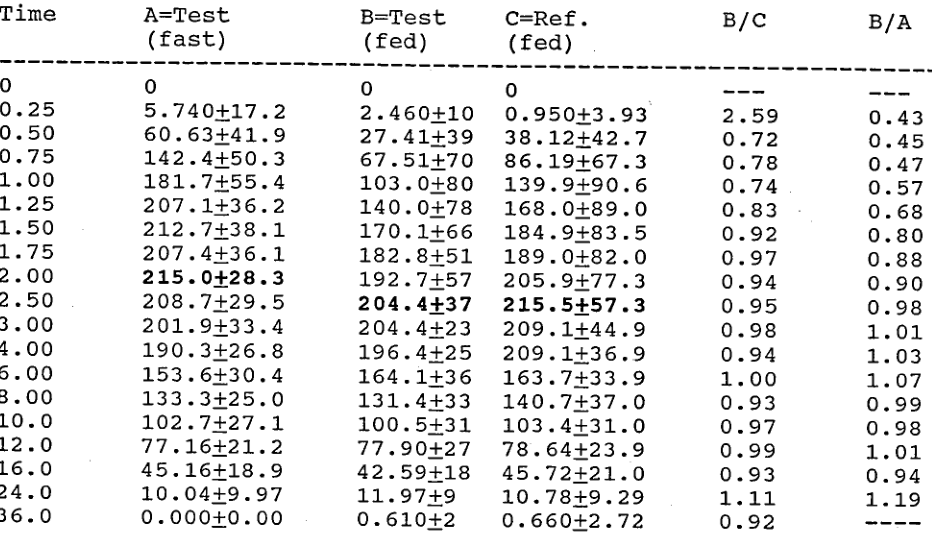

In [108]:
# Let's crop the table image from the page

table_image = images[0].crop(tables_dict['0'][0])

table_image

What's the problem with the above cropped table? Do you see any issues?

What can we do differently?

In [109]:
# Let's add some padding to the box so that we don't crop too close to the table.
padding = 10
table_images = []

for key in tables_dict.keys():
  for box in tables_dict[key]:
    idx = int(key)
    box = [box[0] - padding, box[1] - padding, box[2] + padding, box[3] + padding]
    table_images.append(images[idx].crop(box))

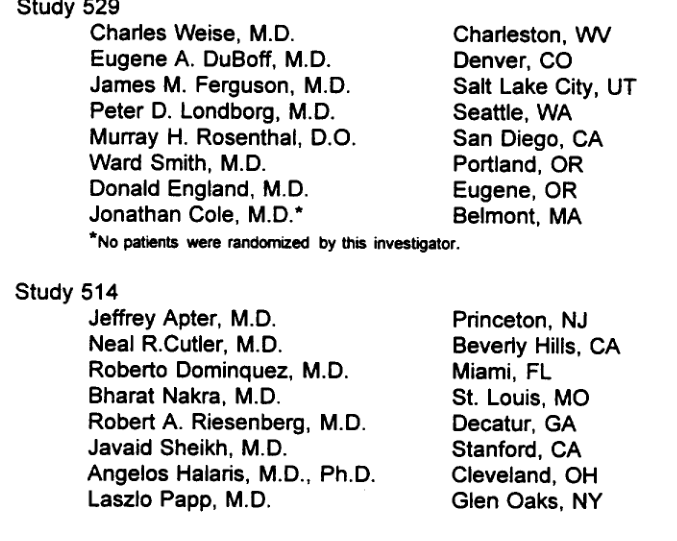

In [77]:
table_images[3]

Let's now do table structure recognition on the table image.

In [110]:
import matplotlib.pyplot as plt
from transformers import DetrFeatureExtractor, DetrForObjectDetection

In [111]:
COLORS = [
    [0.000, 0.447, 0.741],
    [0.850, 0.325, 0.098],
    [0.929, 0.694, 0.125],
    [0.494, 0.184, 0.556],
    [0.466, 0.674, 0.188],
    [0.301, 0.745, 0.933],
]

def plot_simple_box(table_img, bboxes, file_name="output.png"):
    plt.figure(figsize=(16, 10))
    plt.imshow(table_img)
    ax = plt.gca()
    colors = COLORS * 100
    for bbox, c in zip(bboxes, colors):
        ax.add_patch(
            plt.Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1],
                fill=False,
                color=c,
                linewidth=0.5,
            )
        )
    plt.axis("off")
    plt.show()
    plt.savefig(f"{file_name}.png", bbox_inches="tight")

In [112]:
model_structure = TableTransformerForObjectDetection.from_pretrained(
    "microsoft/table-transformer-structure-recognition")


def get_row_col_bounds(table, ts_thresh=0.7, plot=False):
    feature_extractor = DetrFeatureExtractor()
    table_encoding = feature_extractor(table, return_tensors="pt")

    # predict table structure
    with torch.no_grad():
        outputs = model_structure(**table_encoding)

    # visualize table structure
    target_sizes = [table.size[::-1]]
    table_struct_results = feature_extractor.post_process_object_detection(
        outputs, threshold=ts_thresh, target_sizes=target_sizes
    )[0]


    row_boxes = table_struct_results["boxes"][
        table_struct_results["labels"] == model_structure.config.label2id["table row"]
    ]

    row_scores = table_struct_results["scores"][
        table_struct_results["labels"] == model_structure.config.label2id["table row"]
    ]

    col_boxes = table_struct_results["boxes"][
        table_struct_results["labels"]
        == model_structure.config.label2id["table column"]
    ]

    col_scores = table_struct_results["scores"][
        table_struct_results["labels"]
        == model_structure.config.label2id["table column"]
    ]

    table_header_box = table_struct_results["boxes"][
        table_struct_results["labels"]
        == model_structure.config.label2id["table column header"]
    ]
    table_header_score = table_struct_results["scores"][
        table_struct_results["labels"]
        == model_structure.config.label2id["table column header"]
    ]

    print(f"Num rows initially detected: {len(row_boxes)}")
    print(f"Num cols initially detected: {len(col_boxes)}")
    print(f"Num table header detected: {len(table_header_box)}")


    return (
        row_boxes,
        row_scores,
        col_boxes,
        col_scores,
        table_header_box,
        table_header_score,
    )

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [113]:
table_structure_outs = []

for table_image in table_images:
  table_structure_out = get_row_col_bounds(table_image)
  table_structure_outs.append(table_structure_out)

Num rows initially detected: 18
Num cols initially detected: 9
Num table header detected: 1
Num rows initially detected: 1
Num cols initially detected: 5
Num table header detected: 1
Num rows initially detected: 10
Num cols initially detected: 5
Num table header detected: 1
Num rows initially detected: 17
Num cols initially detected: 2
Num table header detected: 0
Num rows initially detected: 11
Num cols initially detected: 11
Num table header detected: 1
Num rows initially detected: 0
Num cols initially detected: 8
Num table header detected: 1
Num rows initially detected: 24
Num cols initially detected: 3
Num table header detected: 1
Num rows initially detected: 2
Num cols initially detected: 4
Num table header detected: 0


In [114]:
## can you identify each of these components?
table_structure_outs

[(tensor([[ 40.0357, 354.5514, 932.3144, 378.8989],
          [ 40.1193, 472.7576, 932.3059, 496.1880],
          [ 40.3620, 145.2840, 932.4430, 169.3805],
          [ 40.0018, 307.0718, 932.4138, 331.5816],
          [ 39.9819, 330.4549, 932.4206, 354.8938],
          [ 40.4454, 192.2798, 932.3846, 216.9047],
          [ 40.3725, 118.8662, 932.7070, 144.0186],
          [ 40.1380,  88.9584, 932.7249, 118.0614],
          [ 39.6236, 259.3799, 932.3916, 283.9585],
          [ 40.6677, 169.6488, 932.3781, 193.8705],
          [ 40.0354, 378.8534, 932.4075, 403.1064],
          [ 40.3116, 449.0779, 932.3995, 472.8403],
          [ 40.1322, 495.8513, 932.6977, 524.4049],
          [ 40.2545, 215.0777, 932.2428, 239.8289],
          [ 39.9119, 282.8240, 932.5232, 307.3685],
          [ 40.4093, 426.1703, 932.4055, 450.1052],
          [ 39.8192, 238.0866, 933.0663, 263.0854],
          [ 40.2252, 403.0464, 932.5326, 427.1909]]),
  tensor([0.9159, 0.9402, 0.8572, 0.9228, 0.9440, 0.8855, 0.81

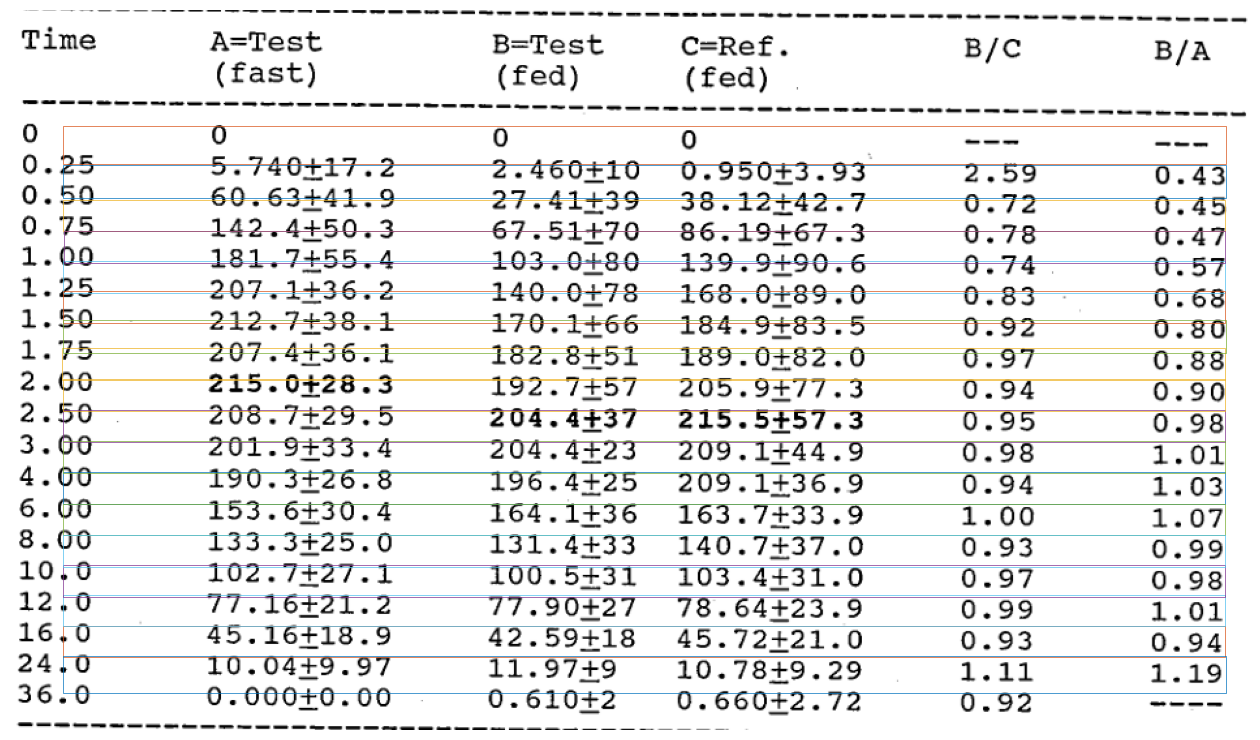

<Figure size 640x480 with 0 Axes>

In [115]:
# Let's visualise the rows first
plot_simple_box(table_images[0], table_structure_outs[0][0])

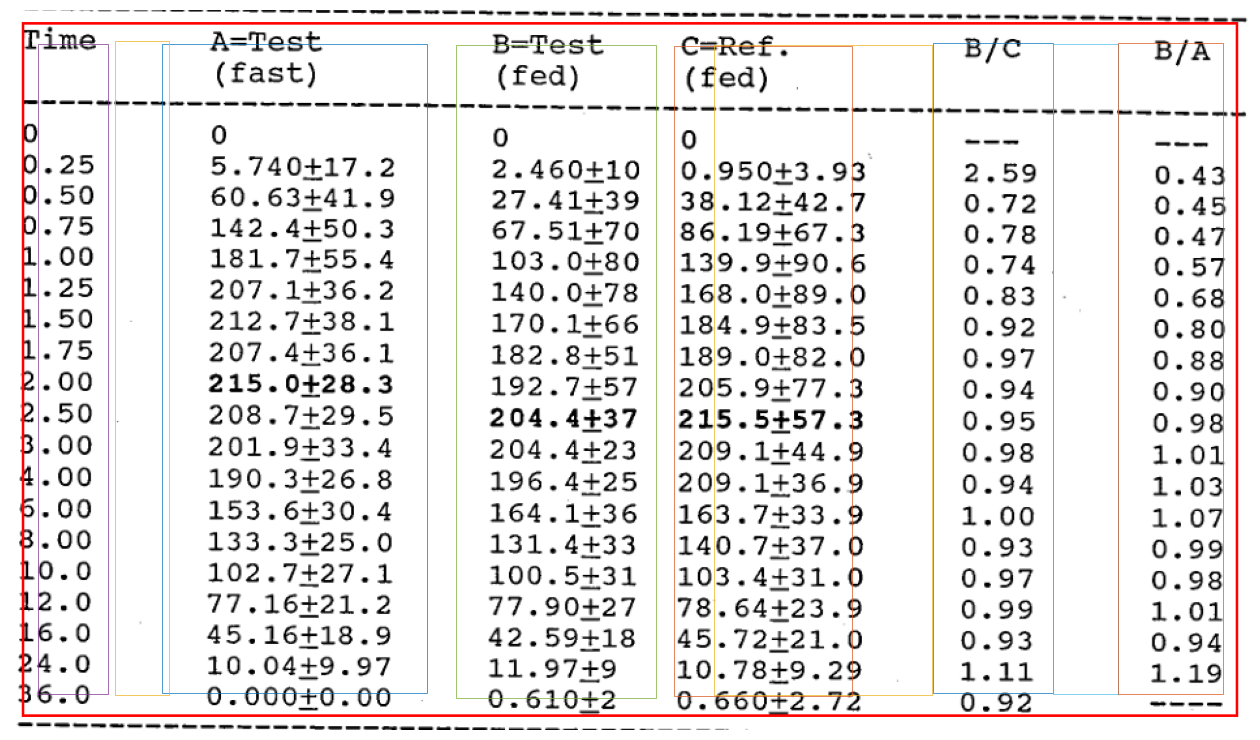

<Figure size 640x480 with 0 Axes>

In [84]:
# Let's visualise the columns
plot_simple_box(table_images[0], table_structure_outs[0][2])

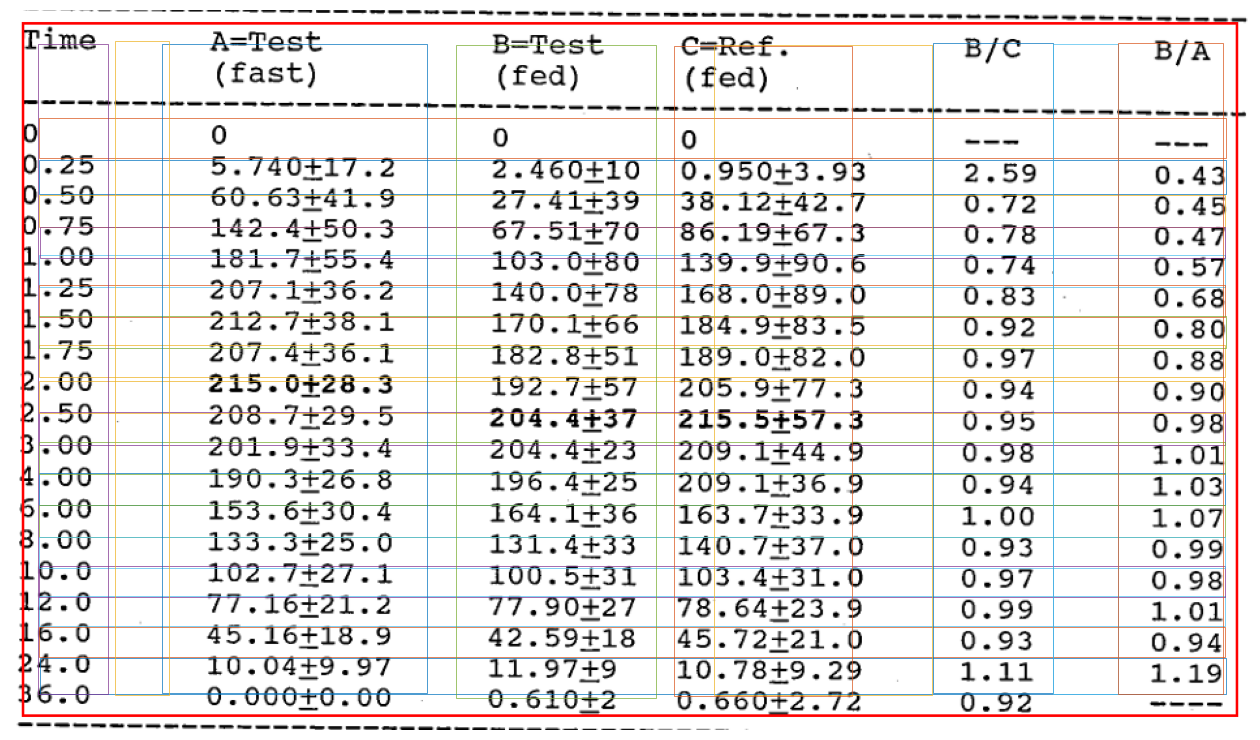

<Figure size 640x480 with 0 Axes>

In [85]:
# Let's visualise rows and columns together
plot_simple_box(table_images[0], table_structure_outs[0][0].tolist() + table_structure_outs[0][2].tolist())

## Decomposing cells

Can you write a function that takes the table_structure_outs and gives a list of cell bboxes?


In [116]:
## your function here
print(table_structure_outs[0][0].tolist())

def list_cell_boxes(row_cells, col_cells):
  cells = []
  for row_cell in row_cells:
    for col_cell in col_cells:
      cell_left_upper_x = col_cell[0]
      cell_left_upper_y = row_cell[1]
      cell_right_lower_x = col_cell[2]
      cell_right_lower_y = row_cell[3]

      cells.append([
          cell_left_upper_x,
          cell_left_upper_y,
          cell_right_lower_x,
          cell_right_lower_y
      ])
  return cells

[[40.03565979003906, 354.5513610839844, 932.3143920898438, 378.89886474609375], [40.1192741394043, 472.757568359375, 932.305908203125, 496.1880187988281], [40.36196517944336, 145.28396606445312, 932.4429931640625, 169.38047790527344], [40.0018424987793, 307.07183837890625, 932.413818359375, 331.5816345214844], [39.981895446777344, 330.45489501953125, 932.4205932617188, 354.8937683105469], [40.445350646972656, 192.27980041503906, 932.3846435546875, 216.9047393798828], [40.37246322631836, 118.86622619628906, 932.7069702148438, 144.01864624023438], [40.137996673583984, 88.95836639404297, 932.7249145507812, 118.0613784790039], [39.62356185913086, 259.3798828125, 932.3916015625, 283.95849609375], [40.667701721191406, 169.64877319335938, 932.3780517578125, 193.87046813964844], [40.035404205322266, 378.8533935546875, 932.4075317382812, 403.1063537597656], [40.31155014038086, 449.0779113769531, 932.3994750976562, 472.8403015136719], [40.13220977783203, 495.85125732421875, 932.6976928710938, 52

In [117]:
cells = list_cell_boxes(table_structure_outs[0][0].tolist(), table_structure_outs[0][2].tolist())

In [118]:
cells

[[705.7017822265625, 354.5513610839844, 799.0371704101562, 378.89886474609375],
 [507.76531982421875,
  354.5513610839844,
  635.0870971679688,
  378.89886474609375],
 [532.4904174804688, 354.5513610839844, 704.6618041992188, 378.89886474609375],
 [39.162574768066406,
  354.5513610839844,
  76.03398132324219,
  378.89886474609375],
 [349.70111083984375, 354.5513610839844, 490.82958984375, 378.89886474609375],
 [799.1306762695312, 354.5513610839844, 848.7736206054688, 378.89886474609375],
 [120.74549102783203,
  354.5513610839844,
  321.4079895019531,
  378.89886474609375],
 [849.7666625976562, 354.5513610839844, 930.7899780273438, 378.89886474609375],
 [80.63980102539062, 354.5513610839844, 125.5512466430664, 378.89886474609375],
 [705.7017822265625, 472.757568359375, 799.0371704101562, 496.1880187988281],
 [507.76531982421875, 472.757568359375, 635.0870971679688, 496.1880187988281],
 [532.4904174804688, 472.757568359375, 704.6618041992188, 496.1880187988281],
 [39.162574768066406, 472

In [119]:
def sort_cells(cells):
  cells.sort(key = lambda x: x[1])
  cells.sort(key = lambda x: x[0])
  return cells

In [120]:
sorted_cells = sort_cells(cells)

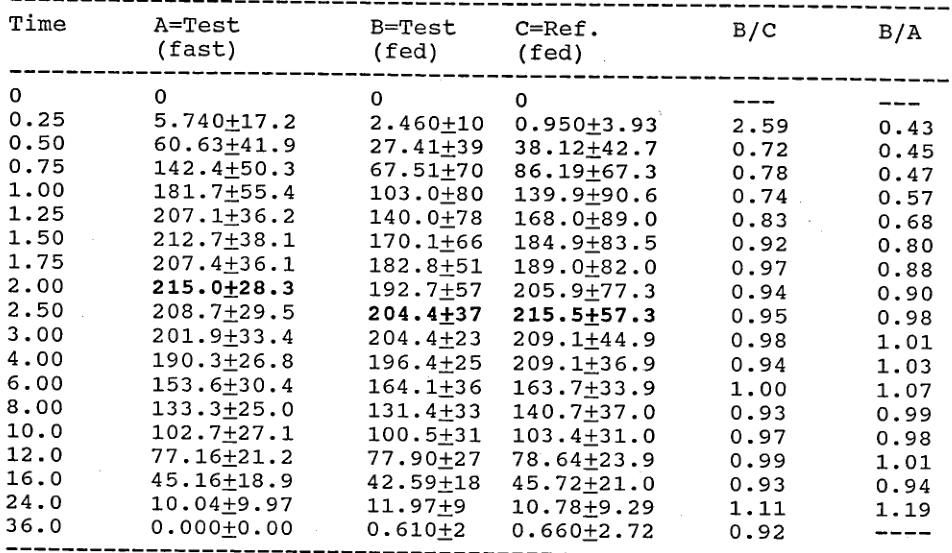

In [121]:
table_images[0]

In [122]:
img_cell = table_images[0].crop(sorted_cells[0])

img_cell

## Cells to DataFrame

Now that you have each cell, what do you need to do get a DataFrame of the table with cell values?

In [34]:
%pip install paddlepaddle paddleocr
%pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.6/544.6 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.1 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=76d7

In [93]:
%pip install paddlepaddle
%pip install "paddleocr>=2.6.0.3"

In [ ]:
import os
import glob
from paddleocr import PaddleOCR,draw_ocr

In [95]:
ocr = PaddleOCR(use_angle_cls=True, lang='en')

download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 3910/3910 [00:20<00:00, 195.39it/s]


download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer/en_PP-OCRv4_rec_infer.tar


100%|██████████| 10000/10000 [00:30<00:00, 330.41it/s]


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2138/2138 [00:15<00:00, 134.51it/s]

[2024/10/18 18:00:04] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

In [130]:
import os
import csv
from paddleocr import PaddleOCR
from PIL import Image
import torch
from transformers import AutoImageProcessor, TableTransformerForObjectDetection

ocr = PaddleOCR(use_angle_cls=True, lang='en')

def extract_text_from_cells(image, cells, ocr_engine):
    extracted_text = []
    for cell_box in cells:
        cell_box = [int(coord.item()) if torch.is_tensor(coord) else int(coord) for coord in cell_box]

        cell_image = image.crop((
            cell_box[0],  # Left
            cell_box[1],  # Top
            cell_box[2],  # Right
            cell_box[3]   # Bottom
        ))

        result = ocr_engine.ocr(cell_image, cls=True)

        cell_text = " ".join([res[1][0] for line in result for res in line]) if result else ""
        extracted_text.append(cell_text)

    return extracted_text


def save_table_as_csv(table_data, output_path):
    with open(output_path, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        for row in table_data:
            writer.writerow(row)

def process_tables_and_save_csv(table_images, model_structure, output_csv_path):
    ocr_engine = PaddleOCR(use_angle_cls=True, lang='en')

    all_table_data = []

    for table_image in table_images:
        row_boxes, col_boxes = get_row_col_bounds(table_image, model_structure)

        cell_boxes = list_cell_boxes(row_boxes, col_boxes)

        extracted_text = extract_text_from_cells(table_image, cell_boxes, ocr_engine)

        table_data = []
        num_cols = len(col_boxes)
        for i in range(0, len(extracted_text), num_cols):
            table_data.append(extracted_text[i:i+num_cols])

        all_table_data.extend(table_data)

    save_table_as_csv(all_table_data, output_csv_path)


[2024/10/18 18:18:06] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

In [133]:
model_structure = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")

output_csv_path = "extracted_table_data.csv"

process_tables_and_save_csv(table_images, model_structure, output_csv_path)

print(f"Table data extracted and saved to {output_csv_path}")

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Table data extracted and saved to extracted_table_data.csv
